## Multi-Step model using TensorFlow

In [1]:
import os
import pandas
import keras
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import IPython
import IPython.display

2023-03-15 16:27:17.107207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:27:17.875458: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 16:27:19.115024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-03-15 16:27:19.117684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
import tqdm

# quietly deep-reload tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

tqdm.__version__

'4.64.1'

In [3]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-15 16:27:21.328913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:27:21.518884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:27:21.519296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
df = pandas.read_csv("Datas/dataset.csv", index_col=0)
# date_time = pandas.to_datetime(df.pop('Date'), format='%d/%m/%Y %H:%M:%S')
columns = list(df.columns)[:-3]
print(columns)
print(df)

['SN Hauteur', 'Montoir Hauteur', 'Paimboeuf Hauteur', 'Cordemais Hauteur', 'LP Hauteur', 'NUB Hauteur', 'NSAL Hauteur']
        SN Hauteur  Montoir Hauteur  Paimboeuf Hauteur  Cordemais Hauteur  \
210486        2.58             2.38               2.17               1.89   
210498        3.91             3.86               3.79               3.58   
210510        5.07             5.10               5.11               5.05   
210522        5.95             6.03               6.10               6.08   
210534        6.28             6.36               6.49               6.53   
...            ...              ...                ...                ...   
939369        4.46             4.50               4.51               4.45   
939381        4.13             4.24               4.33               4.34   
939393        3.50             3.64               3.79               3.87   
939405        2.79             2.87               2.97               3.07   
939417        2.27             2

In [5]:
values = df
#values.pop('Source')
#date_time = pandas.to_datetime(values.pop('Date'), format='%d/%m/%Y %H:%M:%S')
#values["Time"] = [(i)*10 for i in range(len(values))]
#values.drop('Source', axis = 1, inplace = True)
#values['Valeur'] = values['Valeur'].transform(lambda x: int(1000*x))
#print(values)

## Données d'entrainements et de validations

In [6]:
n = len(values)
train_df = values[0:int(n*0.7)]
val_df = values[int(n*0.7):int(n*0.9)]
test_df = values[int(n*0.9):]

num_features = df.shape[1]
print(num_features)

#print(f"Train : {train_df}")
#print(f"Validation : {val_df}")
#print(f"Test : {test_df}")

10


## Fenêtrage des données

In [7]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        #print(features.shape)
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        #print(inputs.shape)
        #print(type(inputs))

        return inputs, labels
    
    def plot(self, model=None, plot_cols=None, max_subplots=3, figname = None, history = None, test = None):
        if plot_cols == None:
            plot_cols = self.label_columns
        print(f"Plot_cols : {plot_cols}")
        

        inputs, labels = self.example

        fig = plt.figure(figsize=(12*len(inputs),4*(len(plot_cols)+1)))

        #print(len(inputs))
        #print(f"inputs : {inputs[0, :, 2]}")
        #print(f"labels : {labels}")
        sub = 1
        max_n = min(max_subplots, len(inputs))
        for plot_col in plot_cols:
            
            plot_col_index = self.column_indices[plot_col]
            #print(self.column_indices)

            for n in range(max_n):
                
                plt.subplot(len(plot_cols)+1, max_n, sub+n)
                plt.ylabel(f'{plot_col}')
                plt.plot([i for i in range(-self.input_width,0)], inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue
                #last = inputs[n, :, time_index][-1]

                plt.scatter([i for i in range(self.label_width)], labels[n, :, label_col_index],
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter([i for i in range(self.label_width)],predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

                if n == 0 and sub == 1:
                    #handles, labels = plt.get_legend_handles_labels()
                    # fig.legend(handles, labels, loc='upper center')
                    
                    if figname != None:
                        font = {'family': 'serif',
                        'weight': 'bold',
                        'size': 16,
                        }
                        plt.title(figname, fontproperties = font, pad = 30)
                    plt.legend( title = "Legend :", facecolor="0.90", edgecolor="black")

            sub+=max_n
            plt.xlabel('Time of Measure')
        
        # Addind a box with loss parameters:
        
        
        if model != None:
            
            h = 0.32
            
            ax = plt.subplot(len(plot_cols)+1, max_n, sub+max_n-1)
            
            text = ax.text(0.5, 0.71, "Metrics :", ha='center', transform=ax.transAxes, fontsize = 12)
            
            textobjs = [text]
            

            
            text = ax.text(0.05,h, 
                           f"Training : \n--------------\nLoss (MSE) : {history.history['loss'][-1] : .3f}\nMAE : {history.history['mean_absolute_error'][-1]: .3f}", 
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            text = ax.text(0.40,h, 
                           f"Validation : \n--------------\nLoss (MSE) : {history.history['val_loss'][-1]: .3f}\nMAE : {history.history['val_mean_absolute_error'][-1]: .3f}",
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            text = ax.text(0.75,h, 
                           f"Test : \n--------------\nLoss (MSE) : {test[0]: .3f}\nMAE : {test[1]: .3f}",
                           ha="left", transform=ax.transAxes, fontsize = 12)
        
            textobjs.append(text)
            
            #t = ax.text(0.4,0.6, 'Hello world line 1', ha='center', color='red', weight='bold', transform=ax.transAxes)
            

            fig.canvas.draw()

            xmin = min([t.get_window_extent().xmin for t in textobjs])*0.85
            xmax = max([t.get_window_extent().xmax for t in textobjs])*1.05
            ymin = min([t.get_window_extent().ymin for t in textobjs])*0.85
            ymax = max([t.get_window_extent().ymax for t in textobjs])*1.1

            xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
            xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))
            
            size = fig.get_size_inches()*fig.dpi

            rect = patches.Rectangle((0,ymin),size[0],ymax-ymin, facecolor='grey', alpha=0.2, transform=fig.transFigure)

            ax.add_patch(rect)

            ax.axis('off')
        
        # Saving the figure
        if figname != None:
            if not os.path.exists("img"):
                 os.makedirs("img")
            fig.savefig("img/" + figname + ".png", bbox_inches='tight')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        #print(data.shape)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=512,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [95]:
w2 = WindowGenerator(input_width=100, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, 
                     label_columns=columns)
w2.label_columns

['SN Hauteur',
 'Montoir Hauteur',
 'Paimboeuf Hauteur',
 'Cordemais Hauteur',
 'LP Hauteur',
 'NUB Hauteur',
 'NSAL Hauteur']

In [96]:
example_window = tf.stack([
                               np.array(train_df[100:100+w2.total_window_size]),
                           ])
print(train_df[:w2.total_window_size].shape)
example_inputs, example_labels = w2.split_window(example_window)
w2._example = example_inputs, example_labels

(101, 10)


Plot_cols : ['SN Hauteur', 'Montoir Hauteur', 'Paimboeuf Hauteur', 'Cordemais Hauteur', 'LP Hauteur', 'NUB Hauteur', 'NSAL Hauteur']


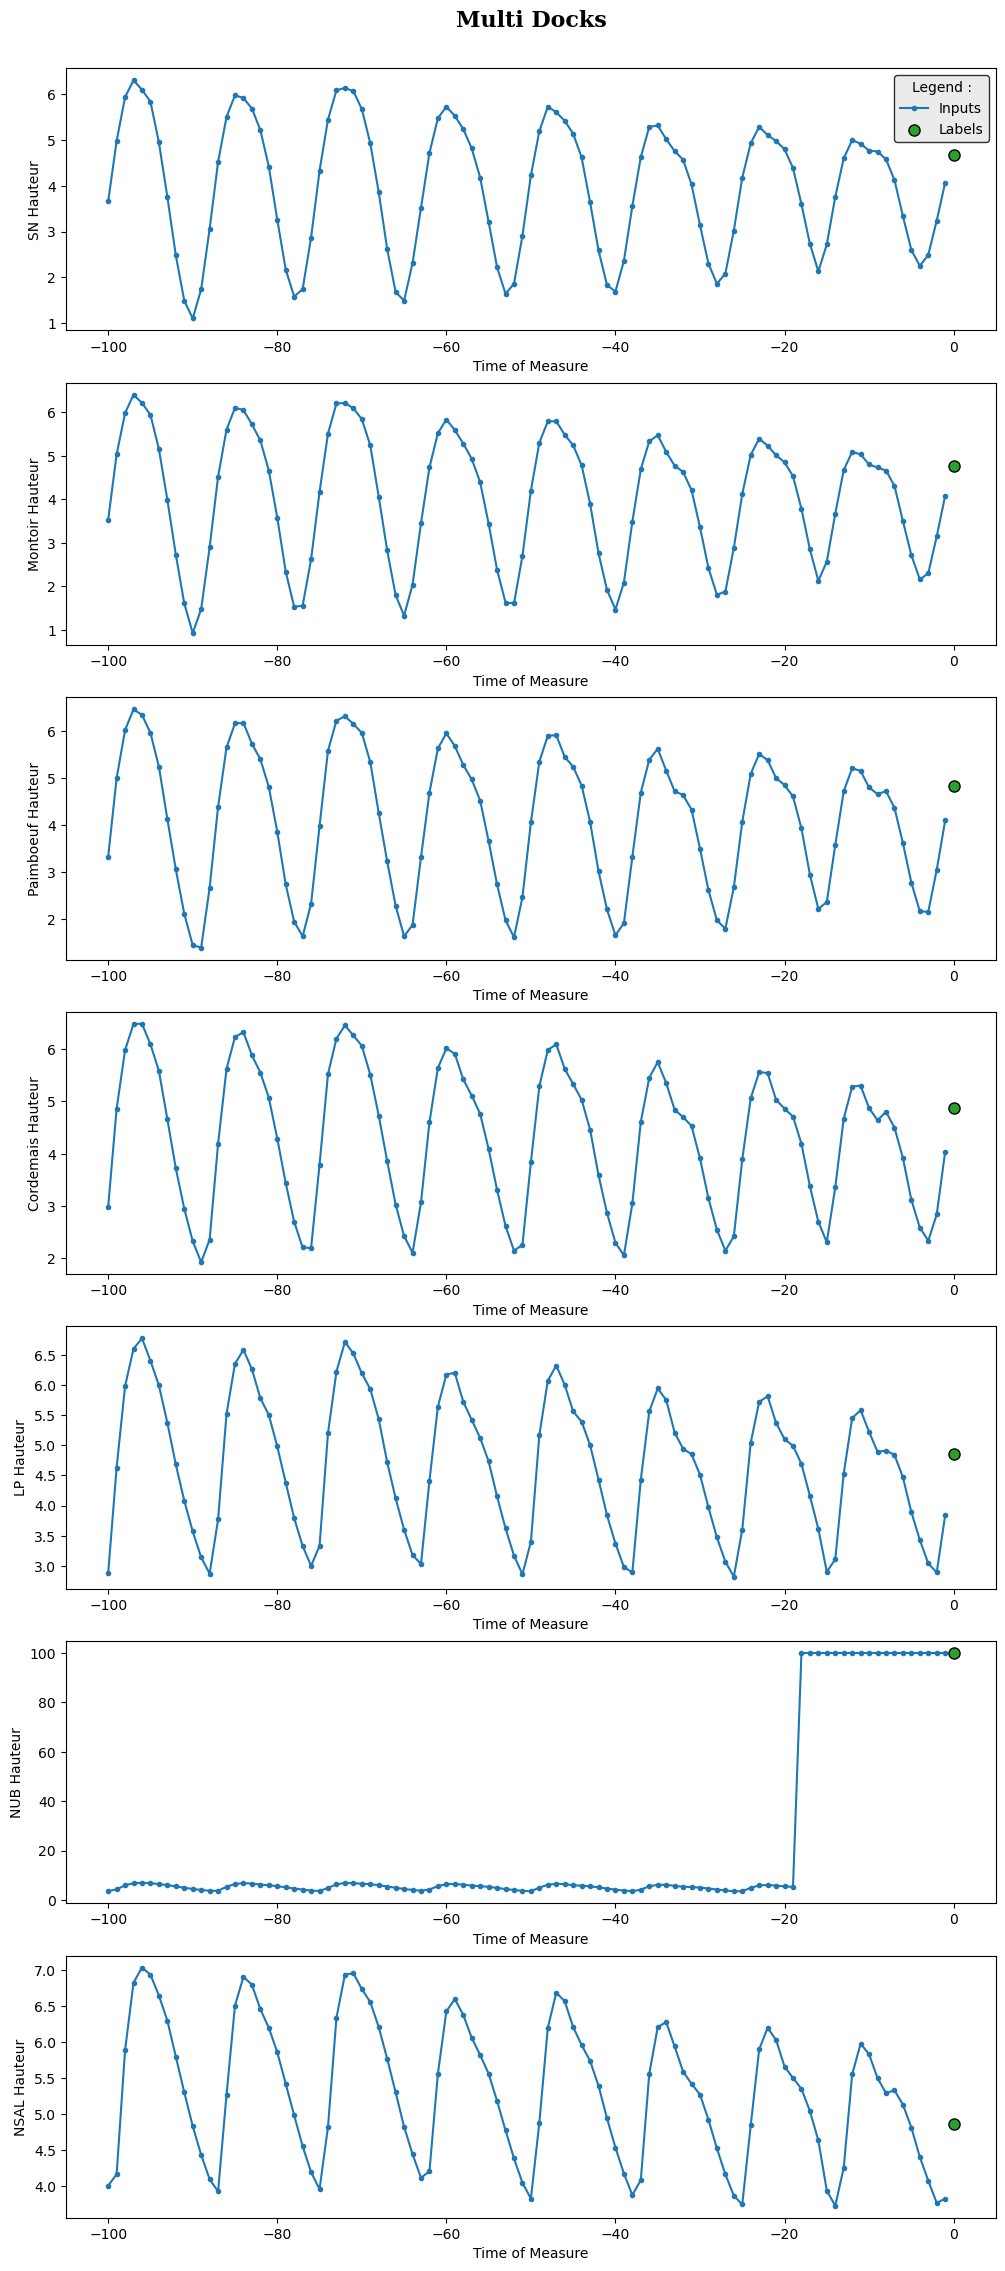

In [97]:
w2.plot(figname="Multi Docks")

### Modèle en une seule étape

In [41]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Valeur'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Valeur']

### Baseline

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [46]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

baseline.fit(single_step_window.train, epochs = 10, steps_per_epoch = 20)

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
20/20 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.1181
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1197
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - mean_absolute_error: 0.1220
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1206
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_error: 0.1214
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.1196
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1200
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0201 - mean_absolute_error: 0.1249
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0189 - mean_absolute_error: 0.1205
Epoch 10/10
2115/21

### Modèle mutli-étapes

2023-03-15 16:27:23.847317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:27:23.850270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:27:23.850765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:27:23.851097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Plot_cols : ['SN Hauteur', 'Montoir Hauteur', 'Paimboeuf Hauteur', 'Cordemais Hauteur', 'LP Hauteur', 'NUB Hauteur', 'NSAL Hauteur']


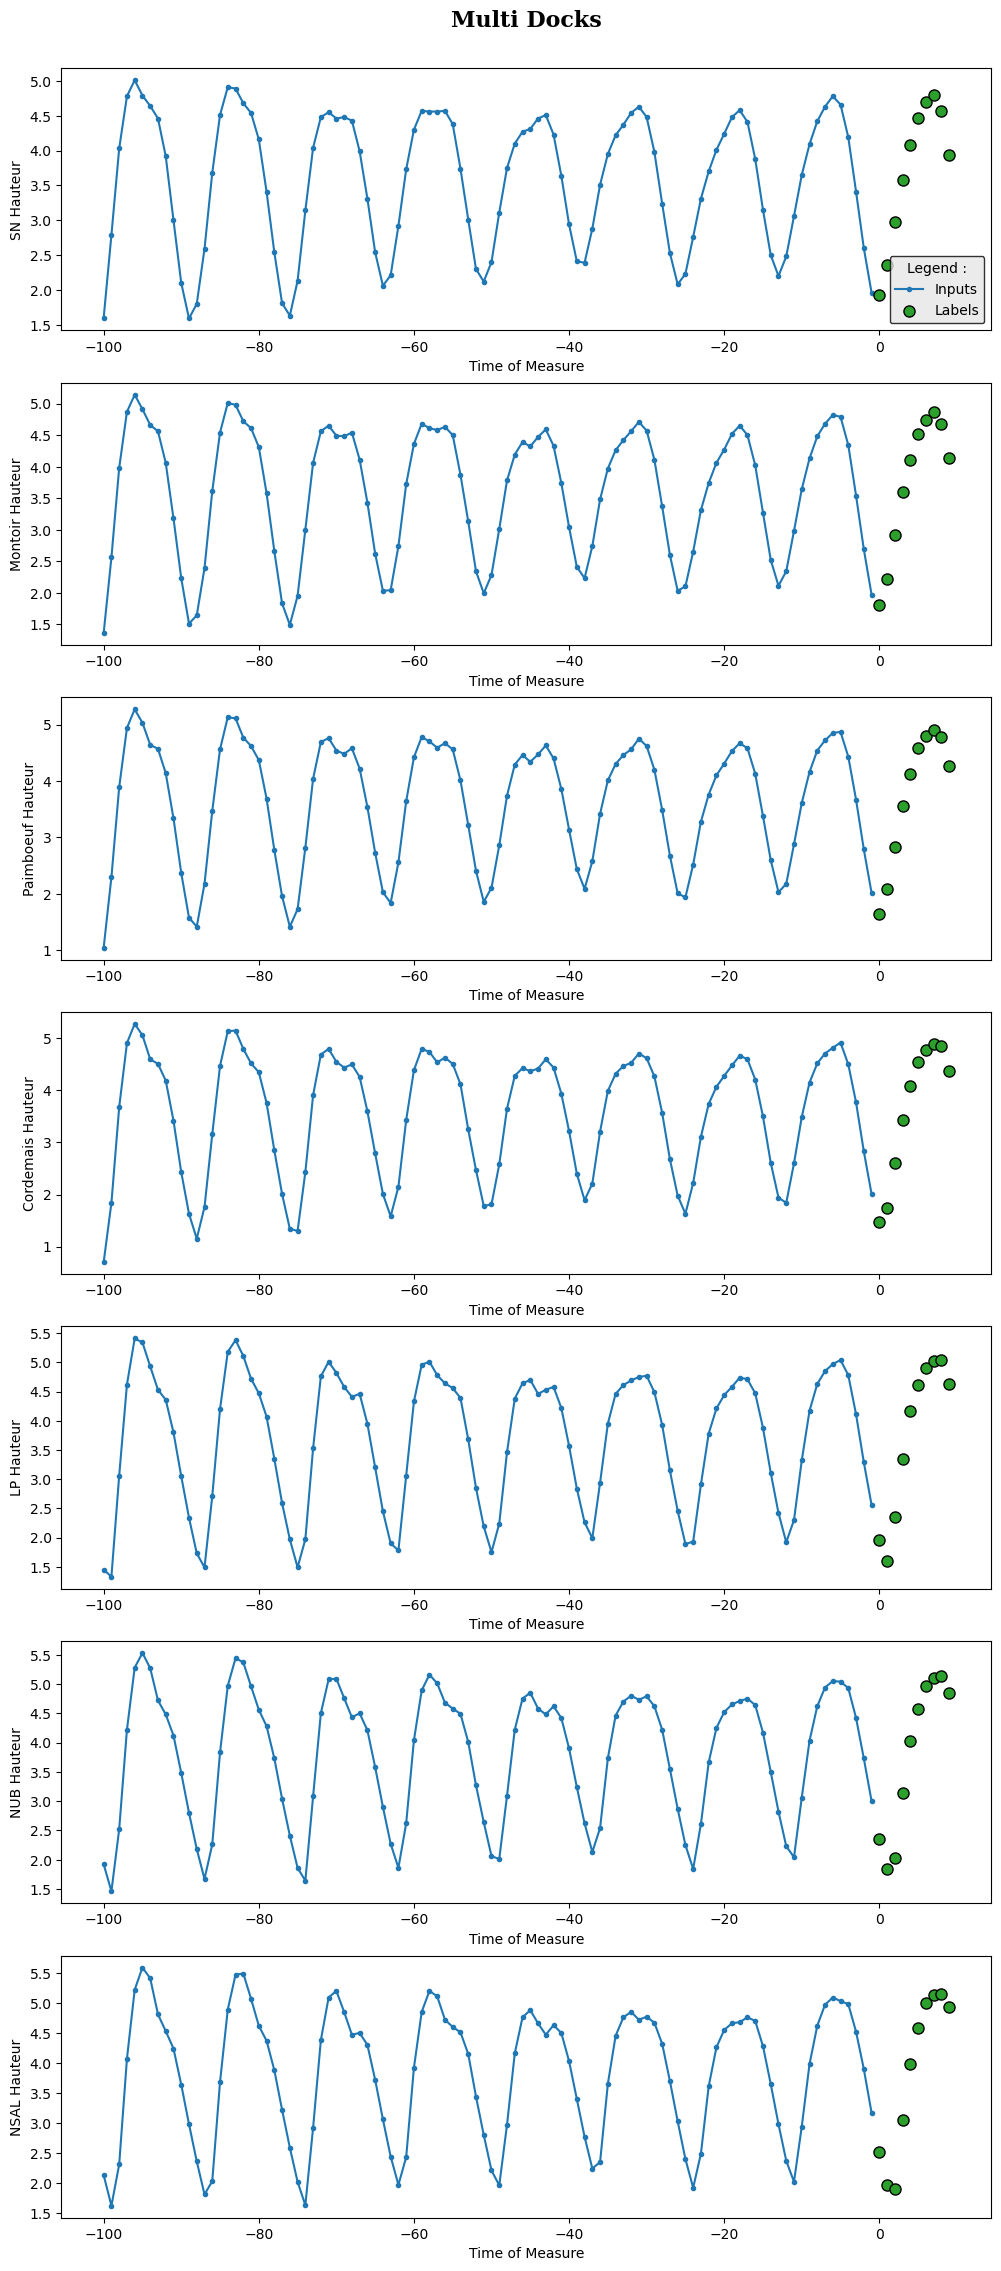

In [8]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=columns)

example_window = tf.stack([np.array(test_df[:multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels
#print(example_inputs)

num_label = len(multi_window.label_columns)

multi_window.plot(figname="Multi Docks")

### Compile and fit

In [9]:
MAX_EPOCHS = 50
tqdm_callback = tfa.callbacks.TQDMProgressBar()
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-6)
    
    #tqdm_callback = tfa.callbacks.TQDMProgressBar()

    model.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["mean_absolute_error"])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[reduce_lr, early_stopping])
    return history

In [10]:
multi_val_performance = {}
multi_performance = {}

In [107]:
multi_window.input_width, len(multi_window.label_columns)

(100, 7)

### Linéaire

In [109]:
multi_linear_model = keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    keras.layers.Lambda(lambda x: x[:, -1:, :]),
    #keras.layers.Flatten(input_shape = (multi_window.input_width, num_features)),
    
    # Shape => [batch, 1, out_steps*features]
    keras.layers.Dense(OUT_STEPS*num_label,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    keras.layers.Reshape([OUT_STEPS, num_label])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_linear_model.summary()

print("Evaluate Validation set")
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
print("Evaluate Test set")
linear_test = multi_linear_model.evaluate(multi_window.test)

multi_performance['Linear'] = linear_test

Epoch 1/2
91/91 [==============================] - 3s 27ms/step - loss: 3.8935 - mean_absolute_error: 1.3494 - val_loss: 1.8696 - val_mean_absolute_error: 1.0985 - lr: 0.0010
Epoch 2/2
91/91 [==============================] - 3s 27ms/step - loss: 2.6472 - mean_absolute_error: 1.0849 - val_loss: 1.5806 - val_mean_absolute_error: 0.9777 - lr: 0.0010
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 1, 10)             0         
                                                                 
 dense_41 (Dense)            (None, 1, 70)             770       
                                                                 
 reshape_33 (Reshape)        (None, 10, 7)             0         
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
___________________________________

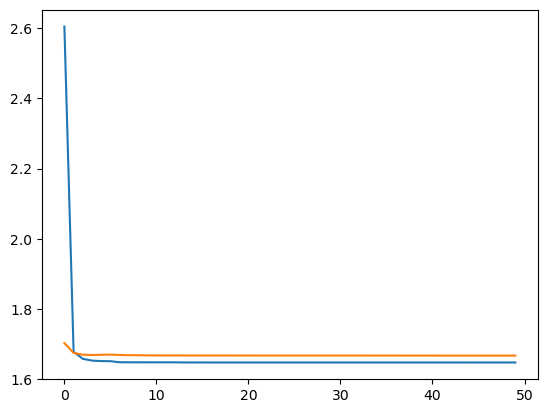

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


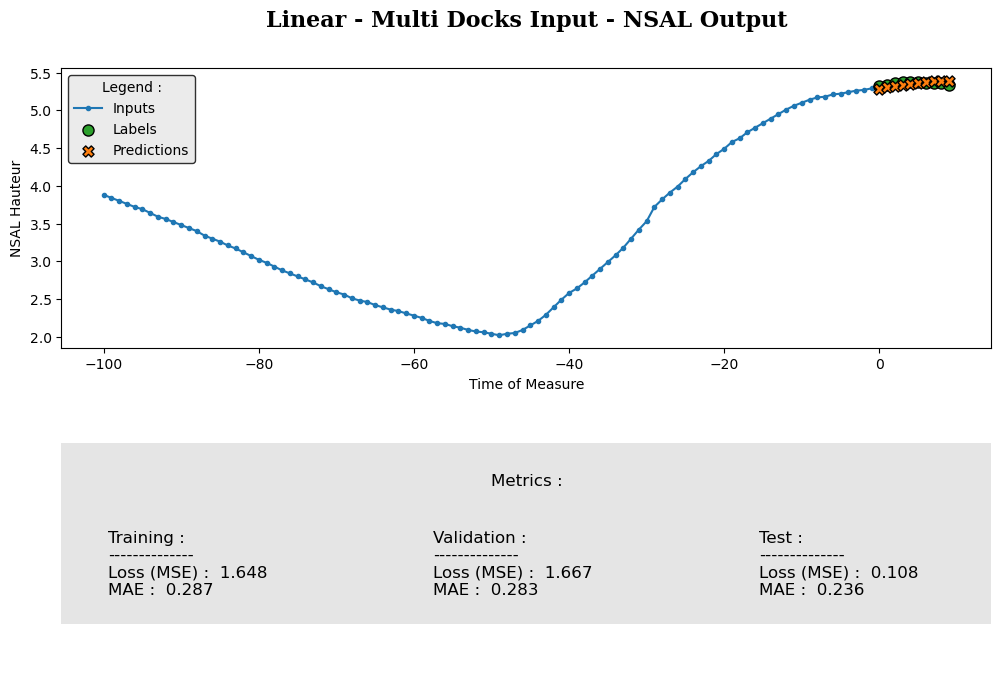

In [21]:
multi_window.plot(multi_linear_model, figname="Linear - Multi Docks Input - NSAL Output", history = history, test = linear_test)

### Dense

In [29]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    keras.layers.Flatten(input_shape = (multi_window.input_width, num_features)),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_label])
])

multi_dense_model.summary()

history = compile_and_fit(multi_dense_model, multi_window)

print("Evaluate Validation set")
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
dense_test = multi_dense_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)
multi_performance['Dense'] = dense_test

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               512512    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 70)                4550      
                                                                 
 reshape_9 (Reshape)         (None, 10, 7)            

79/79 [==============================] - 2s 22ms/step - loss: 1.7736 - mean_absolute_error: 0.6226 - val_loss: 1.1555 - val_mean_absolute_error: 0.5060 - lr: 1.0000e-06
Epoch 40/50
79/79 [==============================] - 2s 22ms/step - loss: 1.7734 - mean_absolute_error: 0.6224 - val_loss: 1.1550 - val_mean_absolute_error: 0.5057 - lr: 1.0000e-06
Epoch 41/50
79/79 [==============================] - 2s 26ms/step - loss: 1.7732 - mean_absolute_error: 0.6223 - val_loss: 1.1548 - val_mean_absolute_error: 0.5055 - lr: 1.0000e-06
Epoch 42/50
79/79 [==============================] - 2s 21ms/step - loss: 1.7730 - mean_absolute_error: 0.6221 - val_loss: 1.1546 - val_mean_absolute_error: 0.5053 - lr: 1.0000e-06
Epoch 43/50
79/79 [==============================] - 2s 22ms/step - loss: 1.7728 - mean_absolute_error: 0.6220 - val_loss: 1.1543 - val_mean_absolute_error: 0.5052 - lr: 1.0000e-06
Epoch 44/50
79/79 [==============================] - 2s 24ms/step - loss: 1.7726 - mean_absolute_error: 0.6

0/23                                                                                                ETA: ?s - …

Evaluate Test set


0/11                                                                                                ETA: ?s - …

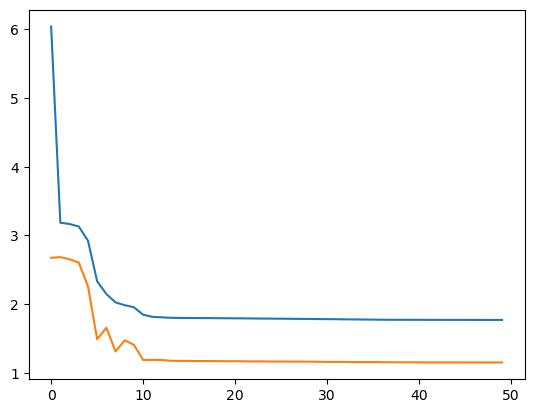

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


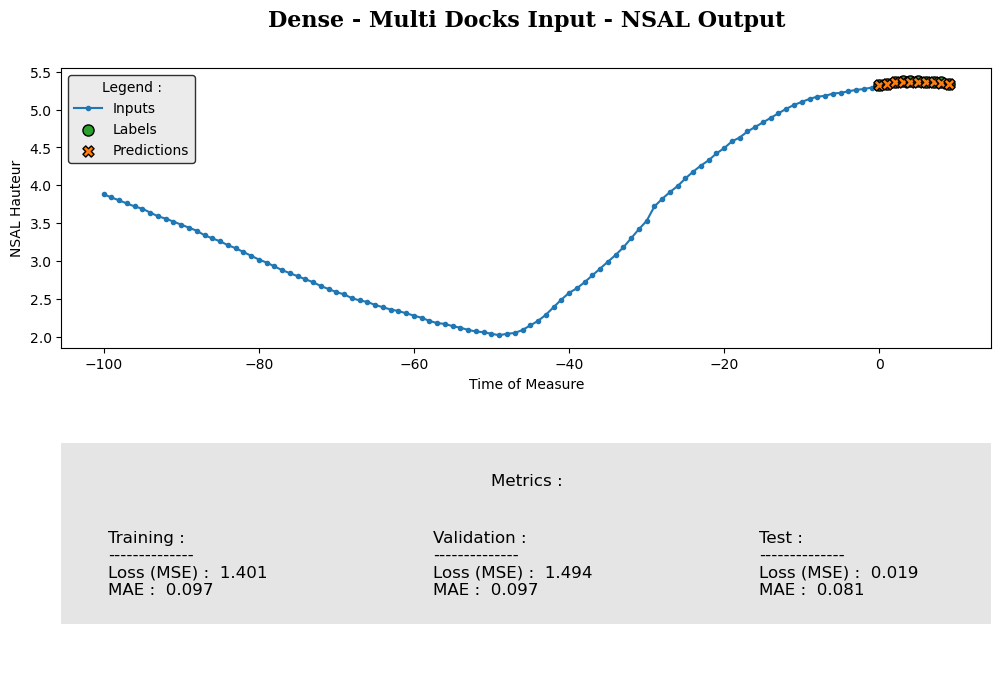

In [25]:
multi_window.plot(multi_dense_model, figname="Dense - Multi Docks Input - NSAL Output", history = history, test = dense_test)

### CNN

In [34]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    tf.keras.layers.Normalization(),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3), padding = "same"),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(3), padding = "same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(3)),
    # Shape => [batch, 1,  out_steps*features]
    
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_label])
])

#multi_conv_model.summary()

history = compile_and_fit(multi_conv_model, multi_window)

multi_conv_model.summary()

print("Evaluate Validation set")
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
cnn_test = multi_conv_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)
multi_performance['Conv'] = cnn_test

Epoch 1/50
79/79 [==============================] - 3s 32ms/step - loss: 3.5455 - mean_absolute_error: 1.3204 - val_loss: 2.6782 - val_mean_absolute_error: 1.2170 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 2s 28ms/step - loss: 3.1445 - mean_absolute_error: 1.2480 - val_loss: 2.5492 - val_mean_absolute_error: 1.1704 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 2s 29ms/step - loss: 2.8011 - mean_absolute_error: 1.1170 - val_loss: 2.3661 - val_mean_absolute_error: 1.0780 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 3s 30ms/step - loss: 2.4372 - mean_absolute_error: 0.9998 - val_loss: 1.7741 - val_mean_absolute_error: 0.8544 - lr: 0.0010
Epoch 5/50
79/79 [==============================] - 2s 29ms/step - loss: 2.3461 - mean_absolute_error: 1.0143 - val_loss: 1.7742 - val_mean_absolute_error: 0.8595 - lr: 0.0010
Epoch 6/50
79/79 [==============================] - 3s 31ms/step - loss: 2.1264 - mean_absolute_error: 0.8579 - val_loss

79/79 [==============================] - 3s 30ms/step - loss: 1.2939 - mean_absolute_error: 0.5272 - val_loss: 1.0805 - val_mean_absolute_error: 0.4504 - lr: 1.0000e-06
Epoch 47/50
79/79 [==============================] - 2s 29ms/step - loss: 1.2938 - mean_absolute_error: 0.5270 - val_loss: 1.0805 - val_mean_absolute_error: 0.4503 - lr: 1.0000e-06
Epoch 48/50
79/79 [==============================] - 2s 29ms/step - loss: 1.2936 - mean_absolute_error: 0.5269 - val_loss: 1.0802 - val_mean_absolute_error: 0.4501 - lr: 1.0000e-06
Epoch 49/50
79/79 [==============================] - 3s 31ms/step - loss: 1.2935 - mean_absolute_error: 0.5269 - val_loss: 1.0801 - val_mean_absolute_error: 0.4500 - lr: 1.0000e-06
Epoch 50/50
79/79 [==============================] - 2s 29ms/step - loss: 1.2934 - mean_absolute_error: 0.5268 - val_loss: 1.0801 - val_mean_absolute_error: 0.4499 - lr: 1.0000e-06
Model: "sequential_10"
_________________________________________________________________
 Layer (type)     

0/23                                                                                                ETA: ?s - …

Evaluate Test set


0/11                                                                                                ETA: ?s - …

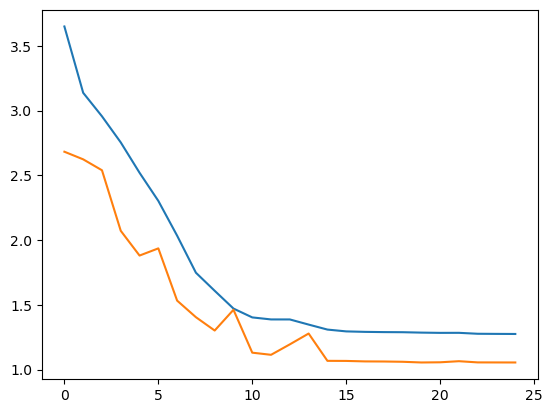

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['NSAL Hauteur']


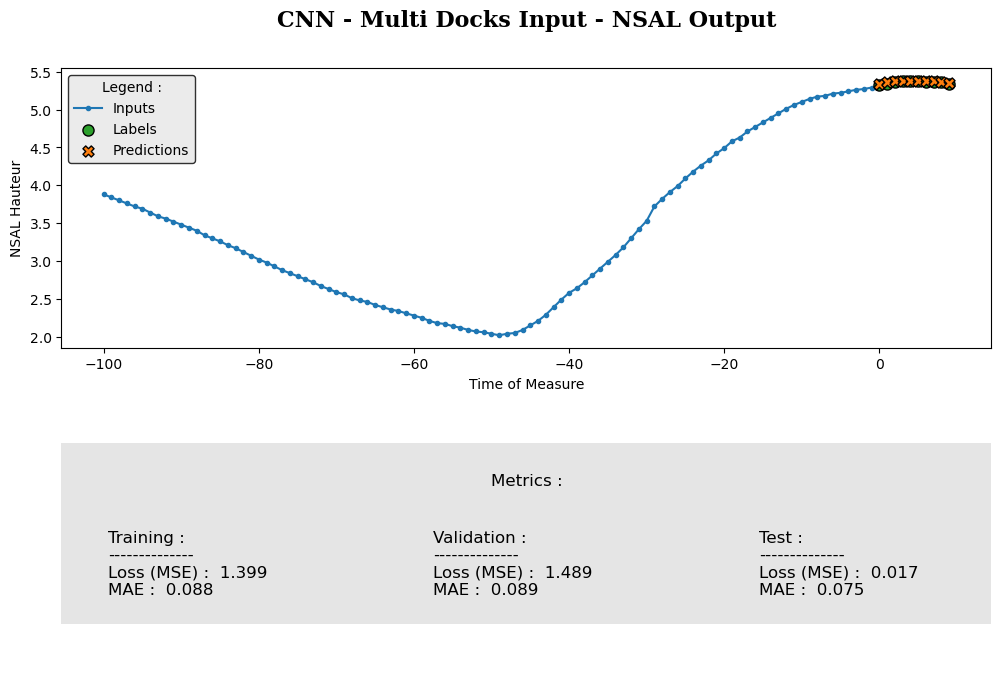

In [29]:
multi_window.plot(multi_conv_model, figname = "CNN - Multi Docks Input - NSAL Output", history = history, test = cnn_test)

In [12]:
multi_conv_model.save("models/MultiCNN")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7facccfa6320>, 140380149621232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6307c0>, 140380149621312), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6324a0>, 140380149623232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc604910>, 140380149622592), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128),

INFO:tensorflow:Assets written to: models/MultiCNN/assets


INFO:tensorflow:Assets written to: models/MultiCNN/assets


### RNN

In [17]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=True, activation = "tanh"),
    tf.keras.layers.LSTM(64, activation = "tanh"),
    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(128),
    
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_label,kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_label])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_lstm_model.summary()

print("Evaluate Validation set")
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, callbacks=[tqdm_callback], verbose=0)
print("Evaluate Test set")
lstm_test = multi_lstm_model.evaluate(multi_window.test, callbacks=[tqdm_callback], verbose=0)
multi_performance['LSTM'] = lstm_test

Epoch 1/50
79/79 [==============================] - 9s 66ms/step - loss: 4.7691 - mean_absolute_error: 1.5507 - val_loss: 2.6775 - val_mean_absolute_error: 1.2123 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 5s 57ms/step - loss: 3.1811 - mean_absolute_error: 1.2570 - val_loss: 2.6760 - val_mean_absolute_error: 1.2089 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 5s 58ms/step - loss: 3.1811 - mean_absolute_error: 1.2567 - val_loss: 2.6741 - val_mean_absolute_error: 1.2098 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 5s 58ms/step - loss: 3.1699 - mean_absolute_error: 1.2553 - val_loss: 2.6633 - val_mean_absolute_error: 1.2029 - lr: 0.0010
Epoch 5/50
79/79 [==============================] - 5s 57ms/step - loss: 3.1512 - mean_absolute_error: 1.2538 - val_loss: 2.6631 - val_mean_absolute_error: 1.2079 - lr: 0.0010
Epoch 6/50
79/79 [==============================] - 5s 58ms/step - loss: 3.1540 - mean_absolute_error: 1.2538 - val_loss

0/23                                                                                                ETA: ?s - …

Evaluate Test set


0/11                                                                                                ETA: ?s - …

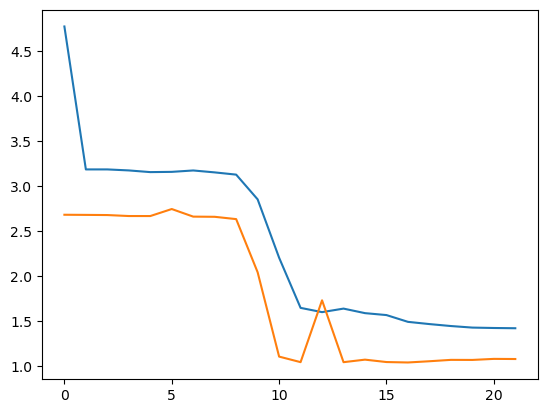

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

Plot_cols : ['SN Hauteur', 'Montoir Hauteur', 'Paimboeuf Hauteur', 'Cordemais Hauteur', 'LP Hauteur', 'NUB Hauteur', 'NSAL Hauteur']


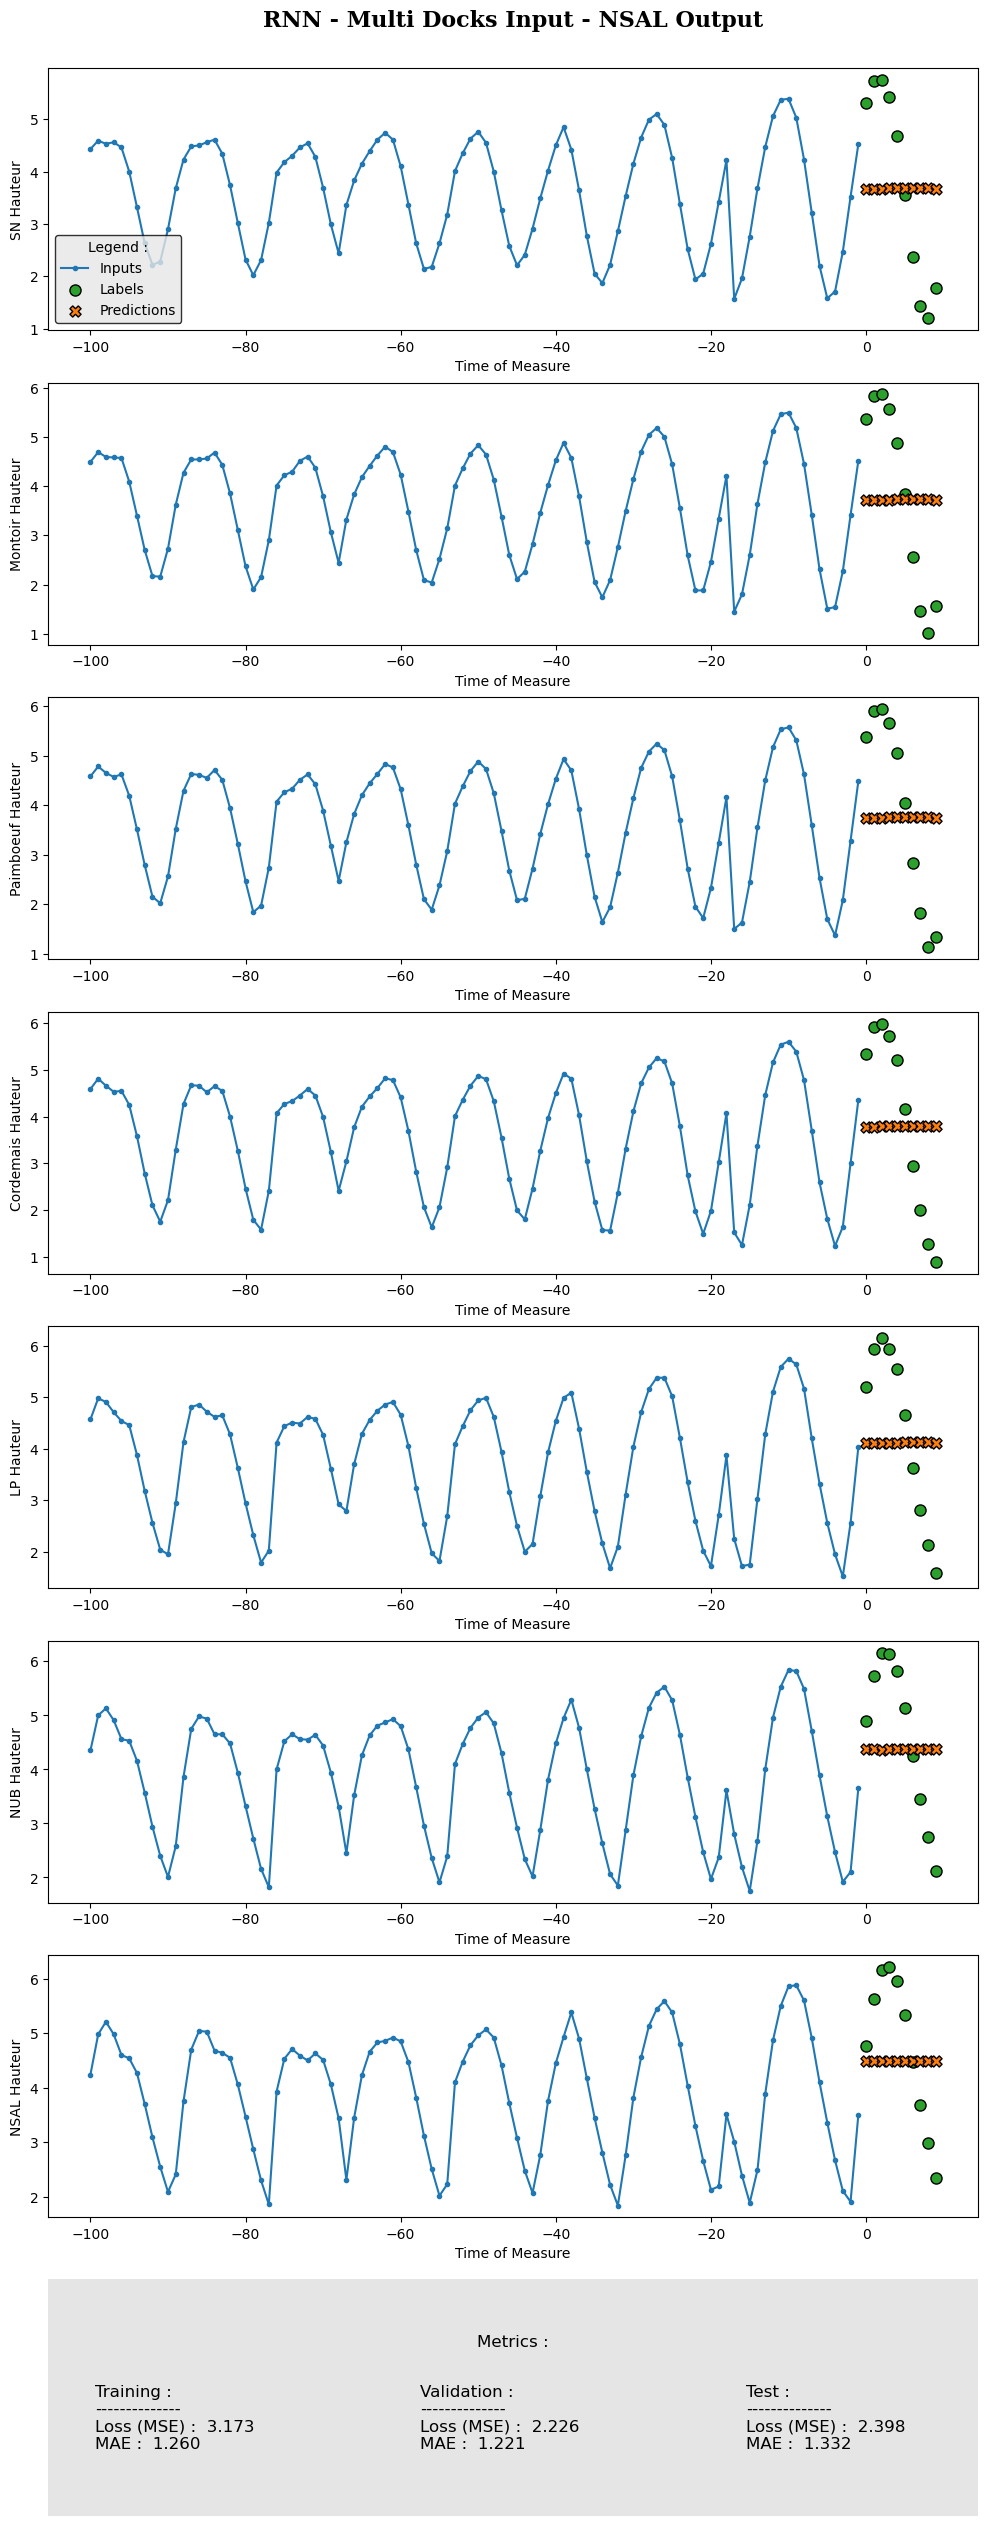

In [114]:
multi_window.plot(multi_lstm_model, figname="RNN - Multi Docks Input - NSAL Output", history = history, test = lstm_test)

(1, 100, 10)
tf.Tensor(
[555. 557. 554. 553. 549. 551. 548. 546. 550. 548. 547. 543. 547. 543.
 540. 544. 537. 541. 537. 537. 534. 530. 534. 527. 530. 524. 521. 526.
 520. 521. 519. 522. 522. 520. 515. 518. 515. 517. 517. 515. 510. 511.
 506. 509. 510. 506. 502. 505. 502. 502. 497. 499. 497. 492. 496. 495.
 490. 492. 492. 487. 487. 490. 489. 486. 485. 481. 483. 479. 479. 476.
 479. 477. 476. 477. 477. 473. 474. 473. 474. 470. 471. 467. 472. 470.
 469. 469. 474. 469. 472. 470. 472. 470. 473. 472. 468. 466. 470. 469.
 469. 468.], shape=(100,), dtype=float64)
1/1 [==============================] - 0s 27ms/step


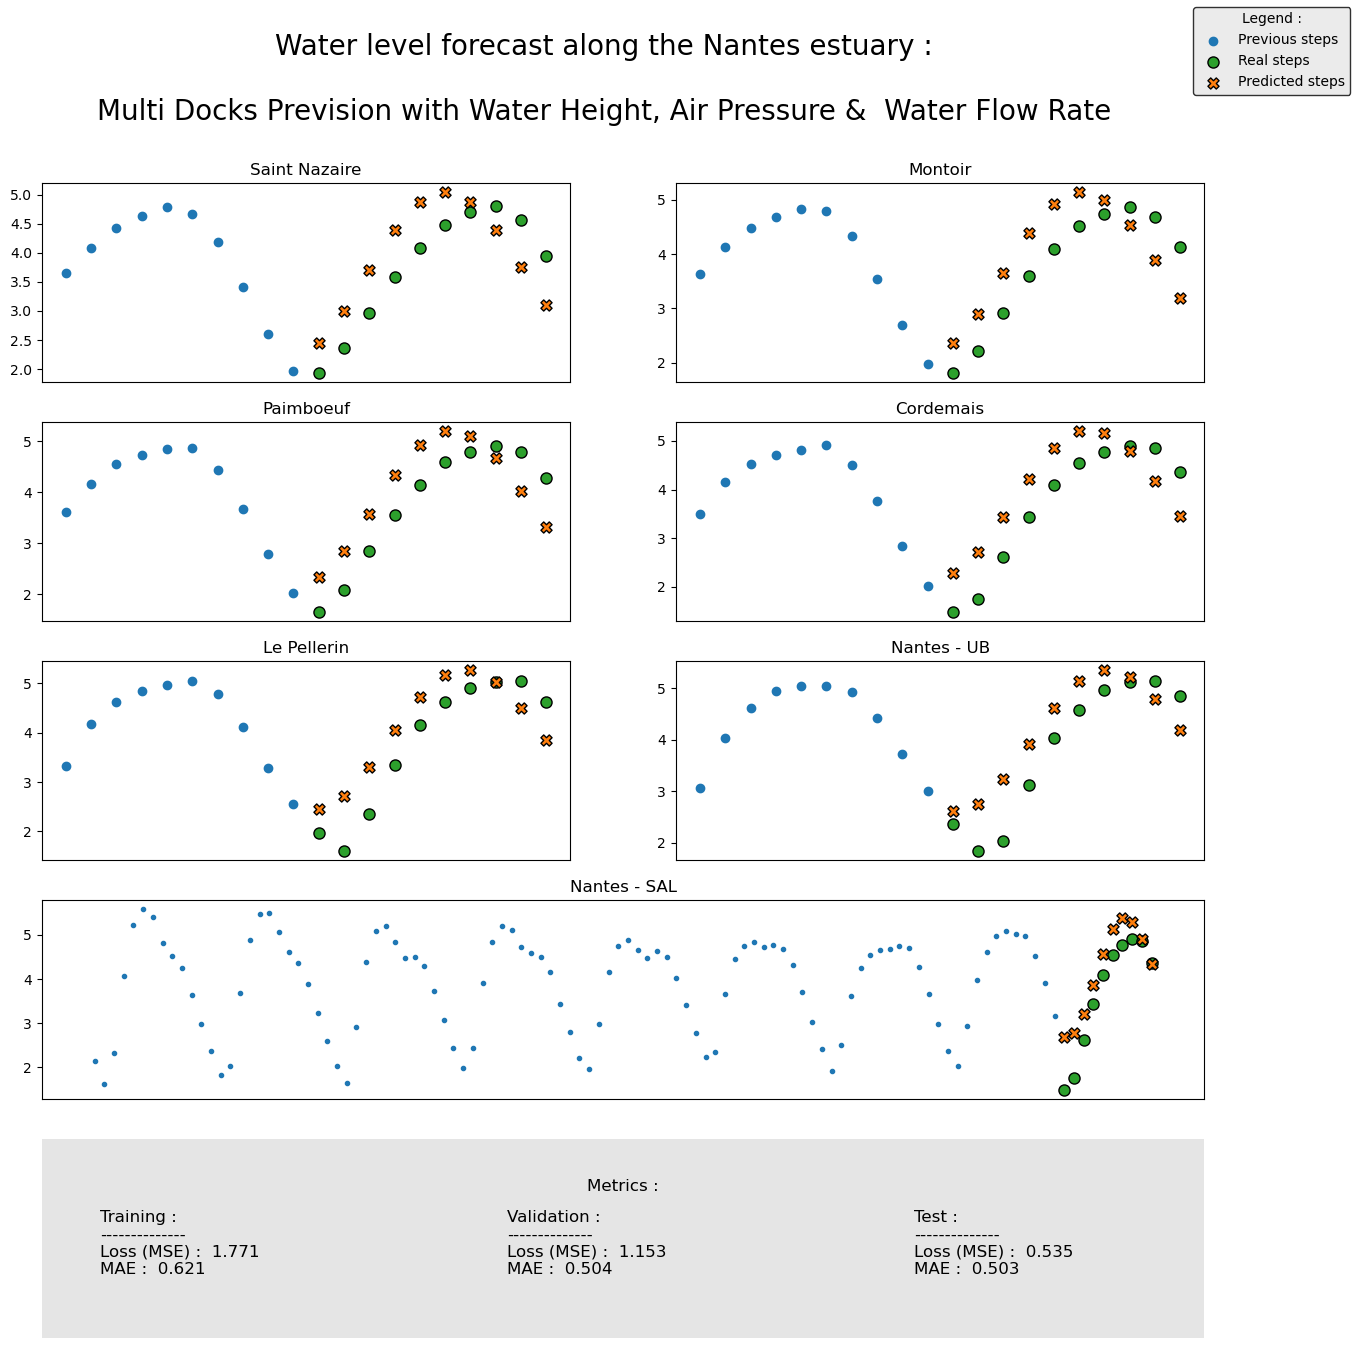

In [33]:
model = multi_dense_model

test, real = multi_window._example
print(test.shape)
print(test[0,:,-1])
pred = model.predict(test)

input_length = multi_window.input_width
output_length = multi_window.label_width


ports =["Saint Nazaire", "Montoir", "Paimboeuf", "Cordemais", "Le Pellerin", "Nantes - UB", "Nantes - SAL"]
abs = [i for i in range(input_length+output_length)]
fig, axs = plt.subplots(5,2, figsize = (15,15))
gs = axs[1, 1].get_gridspec()

axs = axs.reshape([axs.shape[0]*axs.shape[1]])
for ax,i in zip(axs,range(pred.shape[2]-1)):
    ax.set_title(ports[i])
    ax.get_xaxis().set_visible(False)
    ax.scatter(abs[90:input_length], test[0,90:,i], label = "Previous steps")
    ax.scatter(abs[input_length:], real[0,:,i], label = "Real steps", edgecolors='k', c='#2ca02c', s=64)
    ax.scatter(abs[input_length:], pred[0,:,i], label = "Predicted steps", marker = 'X', edgecolors='k',
                            c='#ff7f0e', s=64)
    
handles, labels = ax.get_legend_handles_labels()

for ax in axs[-4:]:
    ax.remove()
    
axbig = fig.add_subplot(gs[-2, :])
axbig.get_xaxis().set_visible(False)
axbig.set_title(ports[-1])
axbig.scatter(abs[:input_length], test[0,:,-4], marker = '.')
axbig.scatter(abs[input_length:], real[0,:,-4], edgecolors='k', c='#2ca02c', s=64)
axbig.scatter(abs[input_length:], pred[0,:,-1], marker = 'X', edgecolors='k', c='#ff7f0e', s=64)


fig.suptitle('Water level forecast along the Nantes estuary :\n\nMulti Docks Prevision with Water Height, Air Pressure &  Water Flow Rate', fontsize=20)

fig.legend(handles, labels, loc='upper right',  title='Legend :', facecolor="0.90", edgecolor="black")


h = 0.32
            
ax = fig.add_subplot(gs[-1,:])
textobjs = []

text = ax.text(0.5, 0.74, "Metrics :", ha='center', transform=ax.transAxes, fontsize = 12)
textobjs.append(text)



text = ax.text(0.05,h, 
               f"Training : \n--------------\nLoss (MSE) : {history.history['loss'][-1] : .3f}\nMAE : {history.history['mean_absolute_error'][-1]: .3f}", 
               ha="left", transform=ax.transAxes, fontsize = 12)

textobjs.append(text)

text = ax.text(0.40,h, 
               f"Validation : \n--------------\nLoss (MSE) : {history.history['val_loss'][-1]: .3f}\nMAE : {history.history['val_mean_absolute_error'][-1]: .3f}",
               ha="left", transform=ax.transAxes, fontsize = 12)

textobjs.append(text)

text = ax.text(0.75,h, 
               f"Test : \n--------------\nLoss (MSE) : {dense_test[0]: .3f}\nMAE : {dense_test[1]: .3f}",
               ha="left", transform=ax.transAxes, fontsize = 12)

textobjs.append(text)

xmin = min([t.get_window_extent().xmin for t in textobjs])*0.85
xmax = max([t.get_window_extent().xmax for t in textobjs])*1.05
ymin = min([t.get_window_extent().ymin for t in textobjs])*0.85
ymax = max([t.get_window_extent().ymax for t in textobjs])*1.1

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

size = fig.get_size_inches()*fig.dpi

rect = patches.Rectangle((0,0),size[0],size[1], facecolor='grey', alpha=0.2, transform=fig.transFigure)

ax.add_patch(rect)

ax.axis('off')

plt.show()
fig.savefig("img/Dense - Multi docks + Pressure & Flow rate.png")

In [33]:
multi_lstm_model.save('models/multi_lstm_model.h5')

In [13]:
multi_lstm_model = tf.keras.models.load_model('models/multi_lstm_model.h5')

['loss', 'mean_absolute_error']


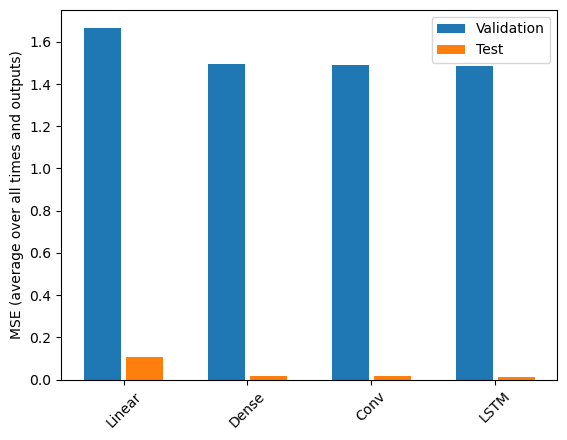

In [34]:
x = np.arange(len(multi_performance))
width = 0.3

print(multi_dense_model.metrics_names)

metric_name = 'mean_squared_error'
metric_index = multi_dense_model.metrics_names.index('loss')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()

### RNN Auto-régréssif

In [35]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [36]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [37]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([1, 7])

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

print("Evaluate Validation set")
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
print("Evaluate Test set")
ar_test = feedback_model.evaluate(multi_window.test, verbose=0)
multi_performance['AR LSTM'] = ar_test

Epoch 1/50
1354/1354 [==============================] - 549s 402ms/step - loss: 2.2599 - mean_absolute_error: 0.4281 - val_loss: 1.5183 - val_mean_absolute_error: 0.1061 - lr: 0.0010
Epoch 2/50
1354/1354 [==============================] - 545s 403ms/step - loss: 1.4185 - mean_absolute_error: 0.1093 - val_loss: 1.5182 - val_mean_absolute_error: 0.1200 - lr: 0.0010
Epoch 3/50
 920/1354 [===================>..........] - ETA: 2:53 - loss: 1.4144 - mean_absolute_error: 0.1014

In [ ]:
multi_window.plot(feedback_model, figname = "RNN Auto-Régressif - Multi Docks Input - NSAL Output", history = history , test = ar_test)

### RNN Perso

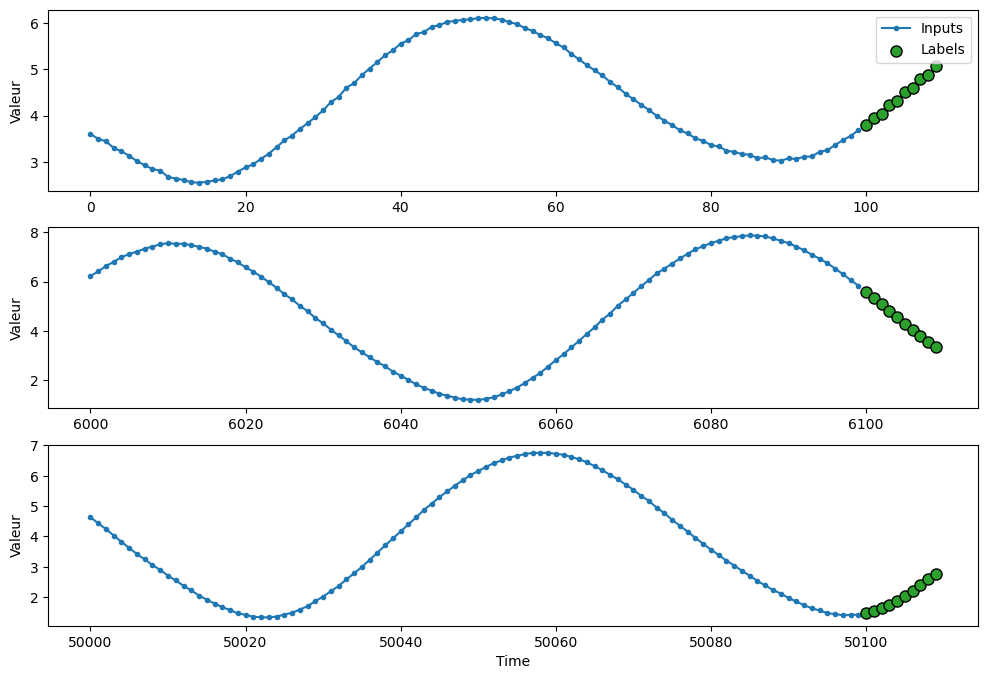

In [24]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[6000:6000+multi_window.total_window_size]),
                           np.array(train_df[50000:50000+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels

multi_window.plot()

In [227]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(
    multi_window.train,
    epochs=5,
    validation_data=multi_window.val,
    validation_steps=3
)

Epoch 1/5
   2/7396 [..............................] - ETA: 8:17 - loss: 19.9042   

model.evaluate(multi_window.test)
multi_window.plot(model)

In [31]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 15.1 MiB
                        values: 15.1 MiB
                      train_df: 10.6 MiB
                        val_df:  3.0 MiB
                       test_df:  1.5 MiB
                           _ii:  4.9 KiB
                          _i29:  4.9 KiB
                          _i22:  4.8 KiB
                          _i13:  4.8 KiB
                           _i7:  4.8 KiB
